In [1]:
import os
if os.name == 'nt':
    !dir "../dataset"
    !dir "../model"
else:
    !dir "../dataset"
    !dir "../model"

 Volume in drive C has no label.
 Volume Serial Number is CACB-8726

 Directory of C:\Users\L\Desktop\work\dataset

11-Feb-19  11:55 PM    <DIR>          .
11-Feb-19  11:55 PM    <DIR>          ..
01-Feb-19  12:34 AM         4,124,645 neg.txt
01-Feb-19  08:52 AM         7,948,509 new_bilstm_neg_tok.pkl
01-Feb-19  08:52 AM        19,913,070 new_bilstm_pos_tok.pkl
01-Feb-19  01:45 AM         7,722,752 new_neg_tok.pkl
01-Feb-19  01:45 AM        19,505,617 new_pos_tok.pkl
01-Feb-19  12:34 AM        10,450,593 pos.txt
11-Feb-19  11:35 PM        46,999,328 sent_neg_int.npy
11-Feb-19  11:13 PM        21,280,430 sent_neg_tok.pkl
11-Feb-19  11:35 PM        51,576,128 sent_pos_int.npy
11-Feb-19  11:13 PM        30,308,235 sent_pos_tok.pkl
08-Feb-19  11:39 PM        13,485,599 sent_raw.csv
11-Feb-19  11:37 PM       122,827,046 train_test_data.npy
11-Feb-19  11:35 PM           232,895 unknown_sent.pkl
01-Feb-19  12:57 AM        15,330,064 vc_redist.x64.exe
08-Nov-18  12:30 AM    <DIR>          won

In [2]:
%matplotlib inline

#matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import itertools


def plot_accnloss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    tick_marks = [0, 1]
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
get_val = lambda arr: list(map(lambda x: x[1], arr))
print('')

In [3]:
import numpy as np
import pandas as pd
import pathlib

from attention import AttentionWithContext

import time, sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Embedding, LSTM, Input
from keras.layers import Activation, Dropout, Flatten, Bidirectional, TimeDistributed, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, utils, regularizers
from keras import backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

import dill as pickle

[x_train, x_test, y_train, y_test] = np.load('../dataset/train_test_data.npy')
x_train = x_train.astype('int32')
x_test = x_test.astype('int32')
print(x_train.shape, y_train.shape)
print(x_train.dtype, y_train.dtype)
print(x_test.shape, y_test.shape)
print(x_test.dtype, y_test.dtype)

print(f'pos size = { len(y_test[np.where( y_test[:,0] == 0 )]) }')
print(f'neg size = { len(y_test[np.where( y_test[:,0] == 1 )]) }')

word_vec = np.load('../model/vec.npy')

print(K.floatx()) # should equal float32

Using TensorFlow backend.


(34912, 600) (34912, 2)
int32 int32
(6161, 600) (6161, 2)
int32 int32
pos size = 3224
neg size = 2937
float32


In [4]:
data_dim = 300
input_len = 600
num_classes = 2

dropout = 0.2
dense_dropout = 0.2
rnn_dropout = 0.1
learning_rate = 1e-3
batch_size = 50
epochs = 50
patience = 5

from keras.layers import AveragePooling1D, LeakyReLU
from keras.initializers import glorot_normal

# sequential
model = Sequential()
model.add(Embedding(len(word_vec), 300, input_length=input_len, weights=[word_vec], trainable=True))

# cnn
def init():
    return glorot_normal(seed=46)
alpha = 0.5
pad = 'same'
activator = 'relu'
kernel_size = 3
pool_size = 2

# model.add(Conv1D(256, kernel_size, padding=pad, activation=activator, kernel_initializer=init()))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(Conv1D(200, kernel_size, padding=pad, activation=activator, kernel_initializer=init()))
# model.add(MaxPooling1D(pool_size=pool_size))

# 2blstm
model.add(Bidirectional(LSTM(150, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
model.add(Bidirectional(LSTM(128, dropout=dropout, recurrent_dropout=rnn_dropout)))

# 2bgru
# model.add(Bidirectional(GRU(100, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(GRU(128, return_sequences=True, dropout=dropout, recurrent_dropout=rnn_dropout)))
# model.add(Bidirectional(GRU(128, dropout=dropout, recurrent_dropout=rnn_dropout)))

# attn (require return_sequences=True)
# model.add(AttentionWithContext())
# model.add(Flatten())

model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(dense_dropout))
model.add(Dense(2, activation='softmax'))

opt = optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 300)          19500000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 300)          541200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 20,513,650
Trainable params: 20,513,650
Non-trainable params: 0
________________________________________________________________

Train on 34912 samples, validate on 6161 samples
Epoch 1/50
34912/34912 [==============================] - 2295s 66ms/step - loss: 0.4510 - acc: 0.7823 - val_loss: 0.2801 - val_acc: 0.8938

Epoch 00001: val_acc improved from -inf to 0.89385, saving model to ../model/result/20190305_204135/model_20190305_204135.hdf5
Epoch 2/50
34912/34912 [==============================] - 2293s 66ms/step - loss: 0.2618 - acc: 0.9027 - val_loss: 0.2484 - val_acc: 0.9065

Epoch 00002: val_acc improved from 0.89385 to 0.90651, saving model to ../model/result/20190305_204135/model_20190305_204135.hdf5
Epoch 3/50
34912/34912 [==============================] - 2354s 67ms/step - loss: 0.2111 - acc: 0.9244 - val_loss: 0.3182 - val_acc: 0.8857

Epoch 00003: val_acc did not improve from 0.90651
Epoch 4/50
34912/34912 [==============================] - 2401s 69ms/step - loss: 0.1794 - acc: 0.9368 - val_loss: 0.2476 - val_acc: 0.9133

Epoch 00004: val_acc improved from 0.90651 to 0.91333, saving model to ../model/

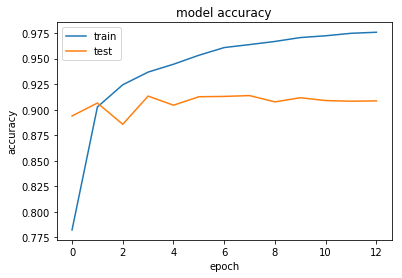

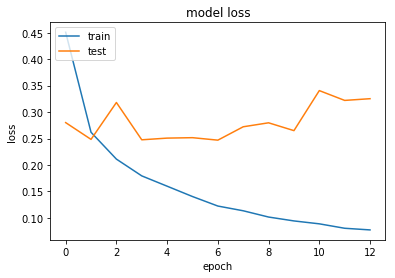

Normalized confusion matrix
[[0.91129032 0.08870968]
 [0.08341845 0.91658155]]


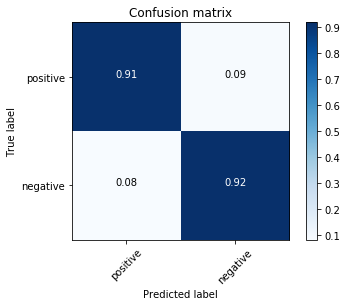

Confusion matrix, without normalization
[[2938  286]
 [ 245 2692]]


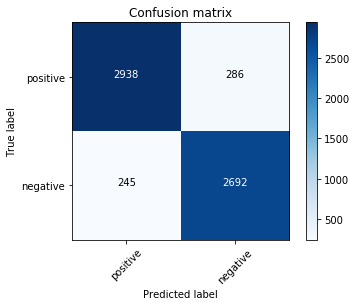

In [5]:
drive_path = '../model/result/'
date = time.strftime('%Y%m%d_%H%M%S')
pathlib.Path(f'{drive_path}{date}').mkdir(parents=True, exist_ok=True)
mon = 'val_acc'
mode_mon = 'max'
file_path = f'{drive_path}{date}/model_{date}.hdf5'
ckpt = ModelCheckpoint(file_path, monitor=mon, verbose=1, save_best_only=True, mode=mode_mon)
early = EarlyStopping(monitor=mon, mode=mode_mon, patience=patience)

histories = []

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[ckpt, early])
del history.model
histories.append(history)

pickle.dump(histories, open(f'{drive_path}{date}/model_{date}_fitting_history.pkl', 'wb'))
        
model_name = f'{drive_path}{date}/model_{date}.h5'
model.save_weights(model_name)
model_json = model.to_json()

with open(f'{drive_path}{date}/model_{date}.json', "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")


model = load_model(file_path, custom_objects={'AttentionWithContext': AttentionWithContext})
print("Load best model from disk")

rand = np.random.choice(len(x_test), 10, replace=False)
for i in rand:
	pre_x, pre_y = x_test[i], y_test[i]
	pre_x = pre_x.reshape(1, input_len)
	res_y = model.predict_classes(pre_x, batch_size=1)
	print('Prediction: {}'.format(res_y[0]))
	print('Result: {}'.format(str(np.where(pre_y==1.)[0])[1]))

score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("{}: {}".format(model.metrics_names[0], score[0]))
print("{}: {}%".format(model.metrics_names[1], score[1]*100))

y_true = get_val(y_test)
y_predict = model.predict_classes(x_test) 

print(metrics.classification_report(y_true, y_predict, target_names = ['negative', 'positive'], digits=6))

with open(f'{drive_path}{date}/model_{date}_result.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('{}: {}\n'.format(model.metrics_names[0], score[0]))
    f.write('{}: {}%\n'.format(model.metrics_names[1], score[1]*100))
    f.write('{}: {}%\n'.format('Report', metrics.classification_report(y_true, y_predict, target_names = ['negative', 'positive'], digits=6)))
    
    
plot_accnloss(history)

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=True,
                      title='Confusion matrix')

plot_confusion_matrix(confusion_matrix(y_true, y_predict, labels=[1,0]), 
                      classes=['positive', 'negative'], 
                      normalize=False,
                      title='Confusion matrix')
